# A Closed Form Solution for Pricing Options: The Black-Scholes Model

## Load the Libs

In [1]:
# import Lib
import pandas as pd
import datetime as dt
import pytz
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as si

# import module
from datetime import datetime, timezone
from datetime import date, time
from math import trunc
from dateutil.parser import parse
from scipy.stats import norm

## Black-Scholes Pricing for Calls and Puts

#### The model function

In [2]:
def mb_black_scholes(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility, option='call'):
    """
    Calculate the Black-Scholes option pricing model.

    Parameters:
    spot_price (float): Spot price of the underlying asset.
    strike_price (float): Strike price of the option.
    time_to_maturity (float): Time to maturity (in years).
    risk_free_rate (float): Risk-free interest rate (annualized).
    volatility (float): Volatility of the underlying asset (annualized).
    option (str): Type of option ('call' or 'put'). Default is 'call'.

    Returns:
    float: The theoretical price of the option based on the Black-Scholes model.
    
    Raises:
    ValueError: If the option type is not recognized.
    """
    d1 = (np.log(spot_price / strike_price) + (risk_free_rate + 0.5 * volatility ** 2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
    d2 = (np.log(spot_price / strike_price) + (risk_free_rate - 0.5 * volatility ** 2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))

    if option == 'call':
        result = (spot_price * si.norm.cdf(d1, 0.0, 1.0) - strike_price * np.exp(-risk_free_rate * time_to_maturity) * si.norm.cdf(d2, 0.0, 1.0))
    elif option == 'put':
        result = (strike_price * np.exp(-risk_free_rate * time_to_maturity) * si.norm.cdf(-d2, 0.0, 1.0) - spot_price * si.norm.cdf(-d1, 0.0, 1.0))
    else:
        raise ValueError("Option type must be 'call' or 'put'.")

    return result


#### Pricing a call and a put

In [3]:
call_price = mb_black_scholes(175, 145, 1, 0.05, 0.35, option = 'call')
put_price = mb_black_scholes(175, 145, 1, 0.05, 0.35, option = 'put')

print(f"The Black-Scholes price of the call option is: {call_price}")
print(f"The Black-Scholes price of the put option is: {put_price}")

The Black-Scholes price of the call option is: 45.037061545347896
The Black-Scholes price of the put option is: 7.965328097951435


## APPL Stock Options Data

#### Read the files into dataframes

In [4]:
mb_src_prices = pd.read_csv("mb_tickerdf04152024 2024-04-15 09-39-43-558192.csv", index_col=0)
mb_src_options = pd.read_csv("mb_all_options_data04152024 2024-04-15 09-39-46-200765.csv", index_col=0)
mb_src_ir = pd.read_csv("mb_US_T_04152024 2024-04-15 09-39-46-240619.csv", index_col=0)

# Parsing the dates in the index and convert them to date only (without time or timezone info)
mb_src_prices.index = mb_src_prices.index.map(lambda x: parse(x).date())

In [5]:
# Prices Dataframe
mb_src_prices

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-04-15,47.793186,48.098844,47.656000,47.949623,70146400,0.0,0.0
2019-04-16,48.004988,48.464674,47.788379,47.954445,102785600,0.0,0.0
2019-04-17,48.024227,48.948421,47.800402,48.888252,115627200,0.0,0.0
2019-04-18,48.885853,49.133747,48.741450,49.063953,96783200,0.0,0.0
2019-04-22,48.816066,49.323890,48.698134,49.225212,77758000,0.0,0.0
...,...,...,...,...,...,...,...
2024-04-09,168.699997,170.080002,168.350006,169.669998,42451200,0.0,0.0
2024-04-10,168.800003,169.089996,167.110001,167.779999,49709300,0.0,0.0
2024-04-11,168.339996,175.460007,168.160004,175.039993,91070300,0.0,0.0


In [6]:
# Take a copy of the prices dataframe
mb_src_prices_HistVol = mb_src_prices.copy()

# Calculate daily returns
mb_src_prices_HistVol['Daily Return'] = mb_src_prices_HistVol['Close'].pct_change()

# Calculate the rolling standard deviation of daily returns (volatility)
# Assuming 252 trading days in a year
mb_src_prices_HistVol['Daily Volatility'] = mb_src_prices_HistVol['Daily Return'].rolling(window=252).std()

# Convert daily volatility to yearly volatility
mb_src_prices_HistVol['Yearly Volatility'] = mb_src_prices_HistVol['Daily Volatility'] * np.sqrt(252)

# Drop NaN values resulting from the rolling window
mb_src_prices_HistVol.dropna(inplace=True)

# Prices and Historical Volatilities Series
mb_src_prices_HistVol

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily Return,Daily Volatility,Yearly Volatility
Date,,,,,,,,,,
2020-04-15,68.856171,69.814401,68.424603,69.351135,131154400,0.0,0.0,-0.009127,0.025510,0.404959
2020-04-16,70.070423,70.270362,68.843984,69.902184,157125200,0.0,0.0,0.007946,0.025513,0.405002
2020-04-17,69.414522,69.965569,67.505369,68.953690,215250000,0.0,0.0,-0.013569,0.025507,0.404904
2020-04-20,67.771160,68.680622,67.502951,67.522453,130015200,0.0,0.0,-0.020756,0.025545,0.405521
2020-04-21,67.363943,67.600454,64.718442,65.435287,180991600,0.0,0.0,-0.030911,0.025627,0.406818
...,...,...,...,...,...,...,...,...,...,...
2024-04-09,168.699997,170.080002,168.350006,169.669998,42451200,0.0,0.0,0.007243,0.012124,0.192459
2024-04-10,168.800003,169.089996,167.110001,167.779999,49709300,0.0,0.0,-0.011139,0.012102,0.192111
2024-04-11,168.339996,175.460007,168.160004,175.039993,91070300,0.0,0.0,0.043271,0.012392,0.196709


In [7]:
# Options Dataframe
mb_src_options

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,OptionType,expirationDate,time_to_expiration
0,AAPL240419C00005000,2024-04-12 13:51:51+00:00,5.0,173.00,0.0,0.0,0.0,0.0,1.0,655,0.00001,True,REGULAR,USD,Call,2024-04-19,3
1,AAPL240419C00010000,2024-03-27 19:35:59+00:00,10.0,163.00,0.0,0.0,0.0,0.0,20.0,11,0.00001,True,REGULAR,USD,Call,2024-04-19,3
2,AAPL240419C00015000,2024-04-04 14:55:59+00:00,15.0,155.95,0.0,0.0,0.0,0.0,1.0,2,0.00001,True,REGULAR,USD,Call,2024-04-19,3
3,AAPL240419C00030000,2024-03-27 15:14:12+00:00,30.0,142.65,0.0,0.0,0.0,0.0,30.0,45,0.00001,True,REGULAR,USD,Call,2024-04-19,3
4,AAPL240419C00035000,2024-04-12 14:02:42+00:00,35.0,142.43,0.0,0.0,0.0,0.0,12.0,3,0.00001,True,REGULAR,USD,Call,2024-04-19,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910,AAPL261218P00210000,2024-04-12 17:59:06+00:00,210.0,39.98,0.0,0.0,0.0,0.0,3.0,5,0.00001,True,REGULAR,USD,Put,2026-12-18,976
1911,AAPL261218P00220000,2024-04-11 19:36:50+00:00,220.0,46.72,0.0,0.0,0.0,0.0,2.0,3,0.00001,True,REGULAR,USD,Put,2026-12-18,976
1912,AAPL261218P00230000,2024-04-11 17:17:27+00:00,230.0,58.15,0.0,0.0,0.0,0.0,2.0,3,0.00001,True,REGULAR,USD,Put,2026-12-18,976
1913,AAPL261218P00280000,2024-04-11 18:22:04+00:00,280.0,106.00,0.0,0.0,0.0,0.0,NaN,1,0.00001,True,REGULAR,USD,Put,2026-12-18,976


In [8]:
# IR Dataframe
mb_src_ir

,US_Treasury_Rates,Yield
0,1m,5.48
1,2m,5.50
2,3m,5.45
3,4m,5.42
4,6m,5.36
5,1y,5.13
6,2y,4.88
7,3y,4.70
8,5y,4.54
9,7y,4.53


In [9]:
"""
This code retrieves and displays information about a specific option based on its strike price and time to expiration from a DataFrame.

Parameters:
- strike_target (float): The target strike price of the option to look for.
- expiration_target (int): The target time to expiration of the option (in days).

The code filters the DataFrame to find the row that matches the specified strike price and time to expiration, 
then transposes the result for easier viewing.
"""

# Define target parameters
strike_target = 220          # Target strike price
expiration_target = 185      # Target time to expiration (in days)

# Retrieve the row corresponding to the specified strike price and expiration time
mb_row_target = mb_src_options.loc[
    (mb_src_options['strike'] == strike_target) & 
    (mb_src_options['time_to_expiration'] == expiration_target)
]

# Transpose the result for better readability
mb_row_target.transpose()

,895,953
contractSymbol,AAPL241018C00220000,AAPL241018P00220000
lastTradeDate,2024-04-12 19:06:19+00:00,2024-02-14 19:37:29+00:00
strike,220.0,220.0
lastPrice,1.64,36.87
bid,0.0,46.6
ask,0.0,49.6
change,0.0,0.0
percentChange,0.0,0.0
volume,786.0,10.0
openInterest,3156,0


In [10]:
# Case #1
call_price1 = mb_black_scholes(175, 220, 0.5, 0.0536, 0.06, option = 'call')
put_price1 = mb_black_scholes(175, 220, 0.5, 0.0536, 0.33, option = 'put')

print(f"The Black-Scholes price of the call option 1 is: {call_price1:.6f}")
print(f"The Black-Scholes price of the put option 1 is: {put_price1:.6f}")

The Black-Scholes price of the call option 1 is: 0.000002
The Black-Scholes price of the put option 1 is: 43.990614


In [11]:
# Case #2
call_price2 = mb_black_scholes(175, 220, 0.5, 0.0536, 0.20, option = 'call')
put_price2 = mb_black_scholes(175, 220, 0.5, 0.0536, 0.20, option = 'put')

print(f"The Black-Scholes price of the call option 2 is: {call_price2:.6f}")
print(f"The Black-Scholes price of the put option 2 is: {put_price2:.6f}")

The Black-Scholes price of the call option 2 is: 0.940593
The Black-Scholes price of the put option 2 is: 40.122899


In [12]:
# Case #3
call_price3 = mb_black_scholes(175, 220, 0.5, 0.0536, 0.15, option = 'call')
put_price3 = mb_black_scholes(175, 220, 0.5, 0.0536, 0.35, option = 'put')

print(f"The Black-Scholes price of the call option 3 is: {call_price3:.6f}")
print(f"The Black-Scholes price of the put option 3 is: {put_price3:.6f}")

The Black-Scholes price of the call option 3 is: 0.223899
The Black-Scholes price of the put option 3 is: 44.752229


## Simulations

#### Spot Ladder

In [13]:
# SPOT LADDER

"""
This code calculates the call and put option prices for a range of spot prices using the Black-Scholes model.

Parameters:
- strike_price: The strike price of the option.
- time_to_maturity: The time remaining until the option expires (in years).
- risk_free_rate: The annualized risk-free interest rate used in the pricing model.
- volatility: The annualized volatility of the underlying asset.

The results are stored in a DataFrame for further analysis and visualization.
"""

# Define parameters
strike_price = 200                # Strike price of the option
time_to_maturity = 1              # Time to maturity (in years)
risk_free_rate = 0.05             # Risk-free interest rate (annualized)
volatility = 0.35                 # Volatility of the underlying asset (annualized)

# Define range for spot price
spot_price_range = np.arange(100, 310, 10)

# Calculate call and put prices for each spot price
call_prices = [mb_black_scholes(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility, option='call') for spot_price in spot_price_range]
put_prices = [mb_black_scholes(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility, option='put') for spot_price in spot_price_range]

# Create DataFrame
mb_df = pd.DataFrame({
    'Spot Price': spot_price_range,
    'Call Price': call_prices,
    'Put Price': put_prices
})

# Display DataFrame
mb_df

,Spot Price,Call Price,Put Price
0,100,0.619309,90.865194
1,110,1.262418,81.508303
2,120,2.299140,72.545025
3,130,3.829395,64.075279
4,140,5.935591,56.181476
5,150,8.676300,48.922185
6,160,12.084155,42.330040
7,170,16.167140,36.413025
8,180,20.912077,31.157962
9,190,26.289185,26.535070


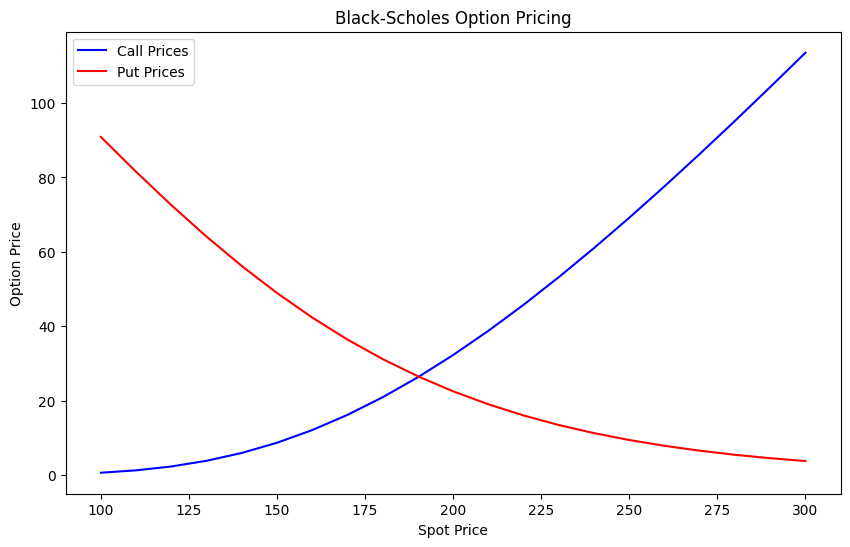

In [14]:
# Set plot size and title
plt.figure(figsize=(10, 6))
plt.title('Black-Scholes Option Pricing')

# Plot call and put prices
plt.plot(mb_df['Spot Price'], mb_df['Call Price'], label='Call Prices', color='blue')
plt.plot(mb_df['Spot Price'], mb_df['Put Price'], label='Put Prices', color='red')

# Set labels and legend
plt.xlabel('Spot Price')
plt.ylabel('Option Price')
plt.legend()

# Display plot
plt.show()

#### Spot and Vol Ladders

In [15]:
# Spot and Vol Ladders
"""
This code calculates call and put option prices for a range of spot prices and volatilities using the Black-Scholes model.

Parameters:
- strike_price: The strike price of the option.
- time_to_maturity: The time remaining until the option expires (in years).
- risk_free_rate: The annualized risk-free interest rate used in the pricing model.
- spot_price_range: A range of possible spot prices for the underlying asset.
- volatility_range: A range of volatility values for the underlying asset.

The results are compiled into a DataFrame that provides a comprehensive view of option prices under varying conditions.
"""

# Define parameters
strike_price = 200                # Strike price of the option
time_to_maturity = 1              # Time to maturity (in years)
risk_free_rate = 0.05             # Risk-free interest rate (annualized)

# Define range for spot price
spot_price_range = np.arange(100, 310, 10)

# Define range for volatility
volatility_range = np.arange(0.15, 0.56, 0.05)

# Calculate call and put prices for each spot price and volatility
vol_ladder = []
for volatility in volatility_range:
    call_prices = [mb_black_scholes(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility, option='call') for spot_price in spot_price_range]
    put_prices = [mb_black_scholes(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility, option='put') for spot_price in spot_price_range]
    
    vol_ladder.append(pd.DataFrame({
        'Volatility': [volatility] * len(spot_price_range),
        'Spot Price': spot_price_range,
        'Call Price': call_prices,
        'Put Price': put_prices
    }))

# Concatenate all dataframes
mb_vol_ladder_df = pd.concat(vol_ladder, ignore_index=True)

# Display the DataFrame
mb_vol_ladder_df


,Volatility,Spot Price,Call Price,Put Price
0,0.15,100,0.000040,90.245925
1,0.15,110,0.000684,80.246569
2,0.15,120,0.006680,70.252565
3,0.15,130,0.041829,60.287714
4,0.15,140,0.183931,50.429816
...,...,...,...,...
184,0.55,260,91.053629,21.299514
185,0.55,270,99.151978,19.397863
186,0.55,280,107.427774,17.673659
187,0.55,290,115.864323,16.110208


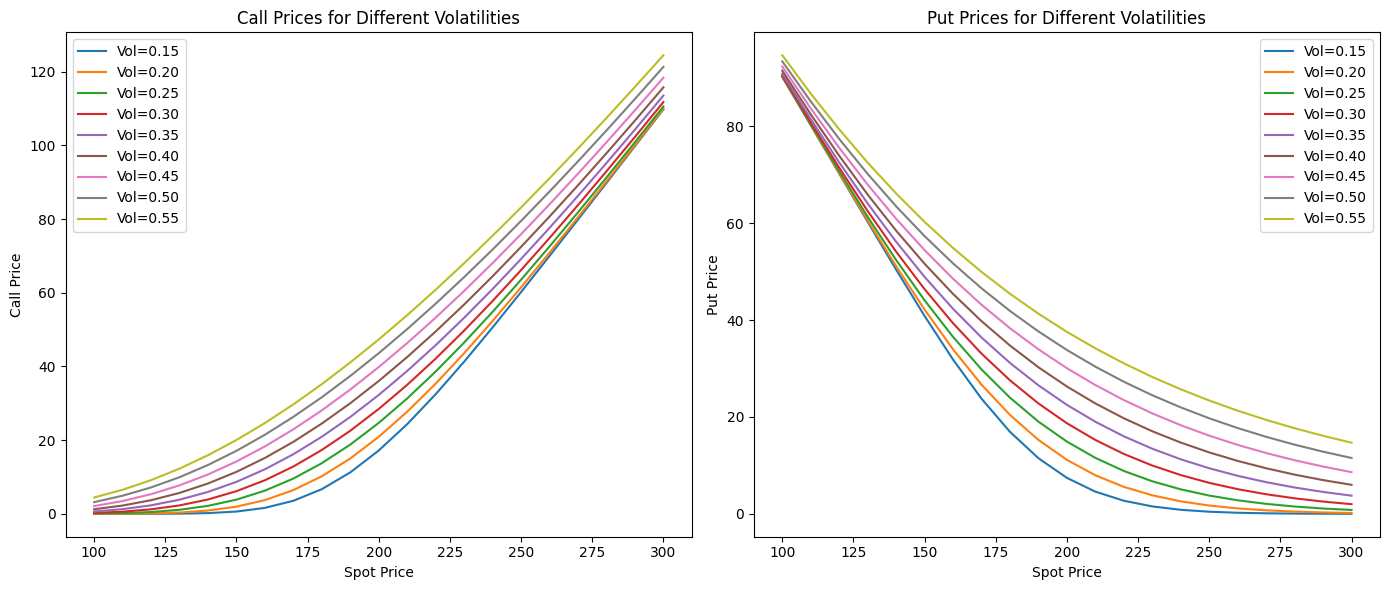

In [16]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

for v in volatility_range:
    mb_df = mb_vol_ladder_df[mb_vol_ladder_df['Volatility'] == v]
    ax[0].plot(mb_df['Spot Price'], mb_df['Call Price'], label=f'Vol={v:.2f}')
    ax[1].plot(mb_df['Spot Price'], mb_df['Put Price'], label=f'Vol={v:.2f}')

ax[0].set_title('Call Prices for Different Volatilities')
ax[0].set_xlabel('Spot Price')
ax[0].set_ylabel('Call Price')
ax[0].legend()

ax[1].set_title('Put Prices for Different Volatilities')
ax[1].set_xlabel('Spot Price')
ax[1].set_ylabel('Put Price')
ax[1].legend()

plt.tight_layout()
plt.show()

## Decoding the Greeks

#### First, let's use the analytical approach, based on the closed-form solution of the Black-Scholes model. 
#### These are the Python functions to calculate the Greeks:

In [17]:
"""
This module contains functions for calculating the Greeks of options using the analytical approach based on the Black-Scholes model.

Functions:
- mb_bs_delta: Calculates the Delta of an option.
- mb_bs_gamma: Calculates the Gamma of an option.
- mb_bs_theta: Calculates the Theta of an option.
- mb_bs_vega: Calculates the Vega of an option.
- mb_bs_rho: Calculates the Rho of an option.
"""

def mb_bs_delta(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility, option='call'):
    """
    Calculate the Delta of an option using the Black-Scholes model.

    Parameters:
    spot_price (float): Current price of the underlying asset.
    strike_price (float): Strike price of the option.
    time_to_maturity (float): Time to maturity (in years).
    risk_free_rate (float): Risk-free interest rate (annualized).
    volatility (float): Volatility of the underlying asset (annualized).
    option (str): Type of option ('call' or 'put'). Default is 'call'.

    Returns:
    float: The Delta of the option.
    """
    d1 = (np.log(spot_price / strike_price) + (risk_free_rate + 0.5 * volatility ** 2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
    if option == 'call':
        delta = si.norm.cdf(d1, 0.0, 1.0)
    elif option == 'put':
        delta = si.norm.cdf(d1, 0.0, 1.0) - 1
    return delta

def mb_bs_gamma(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility):
    """
    Calculate the Gamma of an option using the Black-Scholes model.

    Parameters:
    spot_price (float): Current price of the underlying asset.
    strike_price (float): Strike price of the option.
    time_to_maturity (float): Time to maturity (in years).
    risk_free_rate (float): Risk-free interest rate (annualized).
    volatility (float): Volatility of the underlying asset (annualized).

    Returns:
    float: The Gamma of the option.
    """
    d1 = (np.log(spot_price / strike_price) + (risk_free_rate + 0.5 * volatility ** 2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
    gamma = si.norm.pdf(d1, 0.0, 1.0) / (spot_price * volatility * np.sqrt(time_to_maturity))
    return gamma

def mb_bs_theta(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility, option='call'):
    """
    Calculate the Theta of an option using the Black-Scholes model.

    Parameters:
    spot_price (float): Current price of the underlying asset.
    strike_price (float): Strike price of the option.
    time_to_maturity (float): Time to maturity (in years).
    risk_free_rate (float): Risk-free interest rate (annualized).
    volatility (float): Volatility of the underlying asset (annualized).
    option (str): Type of option ('call' or 'put'). Default is 'call'.

    Returns:
    float: The Theta of the option.
    """
    d1 = (np.log(spot_price / strike_price) + (risk_free_rate + 0.5 * volatility ** 2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
    d2 = d1 - volatility * np.sqrt(time_to_maturity)
    if option == 'call':
        theta = -(spot_price * si.norm.pdf(d1, 0.0, 1.0) * volatility / (2 * np.sqrt(time_to_maturity))) - risk_free_rate * strike_price * np.exp(-risk_free_rate * time_to_maturity) * si.norm.cdf(d2, 0.0, 1.0)
    elif option == 'put':
        theta = -(spot_price * si.norm.pdf(d1, 0.0, 1.0) * volatility / (2 * np.sqrt(time_to_maturity))) + risk_free_rate * strike_price * np.exp(-risk_free_rate * time_to_maturity) * si.norm.cdf(-d2, 0.0, 1.0)
    return theta

def mb_bs_vega(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility):
    """
    Calculate the Vega of an option using the Black-Scholes model.

    Parameters:
    spot_price (float): Current price of the underlying asset.
    strike_price (float): Strike price of the option.
    time_to_maturity (float): Time to maturity (in years).
    risk_free_rate (float): Risk-free interest rate (annualized).
    volatility (float): Volatility of the underlying asset (annualized).

    Returns:
    float: The Vega of the option.
    """
    d1 = (np.log(spot_price / strike_price) + (risk_free_rate + 0.5 * volatility ** 2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
    vega = spot_price * si.norm.pdf(d1, 0.0, 1.0) * np.sqrt(time_to_maturity)
    return vega

def mb_bs_rho(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility, option='call'):
    """
    Calculate the Rho of an option using the Black-Scholes model.

    Parameters:
    spot_price (float): Current price of the underlying asset.
    strike_price (float): Strike price of the option.
    time_to_maturity (float): Time to maturity (in years).
    risk_free_rate (float): Risk-free interest rate (annualized).
    volatility (float): Volatility of the underlying asset (annualized).
    option (str): Type of option ('call' or 'put'). Default is 'call'.

    Returns:
    float: The Rho of the option.
    """
    d2 = (np.log(spot_price / strike_price) + (risk_free_rate - 0.5 * volatility ** 2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
    if option == 'call':
        rho = strike_price * time_to_maturity * np.exp(-risk_free_rate * time_to_maturity) * si.norm.cdf(d2, 0.0, 1.0)
    elif option == 'put':
        rho = -strike_price * time_to_maturity * np.exp(-risk_free_rate * time_to_maturity) * si.norm.cdf(-d2, 0.0, 1.0)
    return rho


### For the numerical approach, we use the concept of finite differences.
### Here, the Greeks are approximated by perturbing each parameter slightly and seeing how much the option price changes:

In [18]:
"""
This module contains functions for calculating the Greeks of options using a numerical approach based on finite differences.

Functions:
- mb_numerical_delta: Calculates the Delta of an option.
- mb_numerical_gamma: Calculates the Gamma of an option.
- mb_numerical_vega: Calculates the Vega of an option.
- mb_numerical_theta: Calculates the Theta of an option.
- mb_numerical_rho: Calculates the Rho of an option.
"""

def mb_numerical_delta(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility, option='call'):
    """
    Calculate the Delta of an option using the numerical approach.

    Parameters:
    spot_price (float): Current price of the underlying asset.
    strike_price (float): Strike price of the option.
    time_to_maturity (float): Time to maturity (in years).
    risk_free_rate (float): Risk-free interest rate (annualized).
    volatility (float): Volatility of the underlying asset (annualized).
    option (str): Type of option ('call' or 'put'). Default is 'call'.

    Returns:
    float: The Delta of the option.
    """
    dS = 0.01 * spot_price
    option_plus = mb_black_scholes(spot_price + dS, strike_price, time_to_maturity, risk_free_rate, volatility, option)
    option_minus = mb_black_scholes(spot_price - dS, strike_price, time_to_maturity, risk_free_rate, volatility, option)
    delta = (option_plus - option_minus) / (2 * dS)
    return delta

def mb_numerical_gamma(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility):
    """
    Calculate the Gamma of an option using the numerical approach.

    Parameters:
    spot_price (float): Current price of the underlying asset.
    strike_price (float): Strike price of the option.
    time_to_maturity (float): Time to maturity (in years).
    risk_free_rate (float): Risk-free interest rate (annualized).
    volatility (float): Volatility of the underlying asset (annualized).

    Returns:
    float: The Gamma of the option.
    """
    dS = 0.01 * spot_price
    delta_plus = mb_numerical_delta(spot_price + dS, strike_price, time_to_maturity, risk_free_rate, volatility)
    delta_minus = mb_numerical_delta(spot_price - dS, strike_price, time_to_maturity, risk_free_rate, volatility)
    gamma = (delta_plus - delta_minus) / (2 * dS)
    return gamma

def mb_numerical_vega(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility):
    """
    Calculate the Vega of an option using the numerical approach.

    Parameters:
    spot_price (float): Current price of the underlying asset.
    strike_price (float): Strike price of the option.
    time_to_maturity (float): Time to maturity (in years).
    risk_free_rate (float): Risk-free interest rate (annualized).
    volatility (float): Volatility of the underlying asset (annualized).

    Returns:
    float: The Vega of the option.
    """
    dv = 0.01 * volatility
    option_plus = mb_black_scholes(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility + dv)
    option_minus = mb_black_scholes(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility - dv)
    vega = (option_plus - option_minus) / (2 * dv)
    return vega

def mb_numerical_theta(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility, option='call'):
    """
    Calculate the Theta of an option using the numerical approach.

    Parameters:
    spot_price (float): Current price of the underlying asset.
    strike_price (float): Strike price of the option.
    time_to_maturity (float): Time to maturity (in years).
    risk_free_rate (float): Risk-free interest rate (annualized).
    volatility (float): Volatility of the underlying asset (annualized).
    option (str): Type of option ('call' or 'put'). Default is 'call'.

    Returns:
    float: The Theta of the option.
    """
    dT = 0.01 * time_to_maturity
    option_plus = mb_black_scholes(spot_price, strike_price, time_to_maturity + dT, risk_free_rate, volatility, option)
    option_minus = mb_black_scholes(spot_price, strike_price, time_to_maturity - dT, risk_free_rate, volatility, option)
    theta = (option_minus - option_plus) / dT  # time decay, theta is negative
    return theta

def mb_numerical_rho(spot_price, strike_price, time_to_maturity, risk_free_rate, volatility, option='call'):
    """
    Calculate the Rho of an option using the numerical approach.

    Parameters:
    spot_price (float): Current price of the underlying asset.
    strike_price (float): Strike price of the option.
    time_to_maturity (float): Time to maturity (in years).
    risk_free_rate (float): Risk-free interest rate (annualized).
    volatility (float): Volatility of the underlying asset (annualized).
    option (str): Type of option ('call' or 'put'). Default is 'call'.

    Returns:
    float: The Rho of the option.
    """
    dr = 0.01 * risk_free_rate
    option_plus = mb_black_scholes(spot_price, strike_price, time_to_maturity, risk_free_rate + dr, volatility, option)
    option_minus = mb_black_scholes(spot_price, strike_price, time_to_maturity, risk_free_rate - dr, volatility, option)
    rho = (option_plus - option_minus) / (2 * dr)
    return rho


#### Greeks functions test

In [19]:
"""
This module calculates the Greeks of options (Delta, Gamma, Vega, Theta, Rho)
using both analytical and numerical approaches based on the Black-Scholes model.
"""

# Calculate the Greeks
# Delta
call_analytical_delta = mb_bs_delta(175, 145, 1, 0.05, 0.35, option='call')
call_numerical_delta = mb_numerical_delta(175, 145, 1, 0.05, 0.35, option='call')
put_analytical_delta = mb_bs_delta(175, 145, 1, 0.05, 0.35, option='put')
put_numerical_delta = mb_numerical_delta(175, 145, 1, 0.05, 0.35, option='put')

# Gamma
analytical_gamma = mb_bs_gamma(175, 145, 1, 0.05, 0.35)
numerical_gamma = mb_numerical_gamma(175, 145, 1, 0.05, 0.35)

# Vega
analytical_vega = mb_bs_vega(175, 145, 1, 0.05, 0.35)
numerical_vega = mb_numerical_vega(175, 145, 1, 0.05, 0.35)

# Theta
call_analytical_theta = mb_bs_theta(175, 145, 1, 0.05, 0.35, option='call')
call_numerical_theta = mb_numerical_theta(175, 145, 1, 0.05, 0.35, option='call')
put_analytical_theta = mb_bs_theta(175, 145, 1, 0.05, 0.35, option='put')
put_numerical_theta = mb_numerical_theta(175, 145, 1, 0.05, 0.35, option='put')

# Rho
call_analytical_rho = mb_bs_rho(175, 145, 1, 0.05, 0.35, option='call')
call_numerical_rho = mb_numerical_rho(175, 145, 1, 0.05, 0.35, option='call')
put_analytical_rho = mb_bs_rho(175, 145, 1, 0.05, 0.35, option='put')
put_numerical_rho = mb_numerical_rho(175, 145, 1, 0.05, 0.35, option='put')

# Create a DataFrame for organized output
results = pd.DataFrame({
    'Greek': ['Delta', 'Delta', 'Gamma', 'Gamma', 'Vega', 'Vega', 'Theta', 'Theta', 'Rho', 'Rho'],
    'Option Type': ['Call', 'Put', 'Call', 'Put', 'Call', 'Put', 'Call', 'Put', 'Call', 'Put'],
    'Analytical': [
        round(call_analytical_delta, 4),
        round(put_analytical_delta, 4),
        round(analytical_gamma, 4),
        round(numerical_gamma, 4),
        round(analytical_vega, 4),
        round(numerical_vega, 4),
        round(call_analytical_theta, 4),
        round(put_analytical_theta, 4),
        round(call_analytical_rho, 4),
        round(put_analytical_rho, 4)
    ],
    'Numerical': [
        round(call_numerical_delta, 4),
        round(put_numerical_delta, 4),
        round(numerical_gamma, 4),
        round(numerical_gamma, 4),
        round(numerical_vega, 4),
        round(numerical_vega, 4),
        round(call_numerical_theta, 4),
        round(put_numerical_theta, 4),
        round(call_numerical_rho, 4),
        round(put_numerical_rho, 4)
    ]
})

# Display the results in a table format
results

,Greek,Option Type,Analytical,Numerical
0,Delta,Call,0.8038,0.8037
1,Delta,Put,-0.1962,-0.1963
2,Gamma,Call,0.0045,0.0045
3,Gamma,Put,0.0045,0.0045
4,Vega,Call,48.4343,48.4333
5,Vega,Put,48.4333,48.4333
6,Theta,Call,-13.2571,-26.5143
7,Theta,Put,-6.3607,-12.7215
8,Rho,Call,95.6219,95.6219
9,Rho,Put,-42.3063,-42.3063
